In [32]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from diffusers import DDPMPipeline
from datasets import load_dataset
from diffusers import DDPMScheduler, DDIMScheduler
from diffusers import UNet2DModel
import gc
from tqdm.auto import tqdm
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
dataset = torchvision.datasets.FashionMNIST(root="../../data/fashion_mnist", train=True, download=True, transform=transforms.ToTensor())

In [4]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True, num_workers=8)

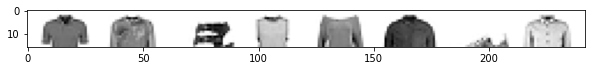

In [8]:
x, y = next(iter(train_loader))
plt.figure(figsize=(10, 7))
plt.imshow(torchvision.utils.make_grid(x)[0][:16], cmap="Greys")

In [9]:
class ClassConditionedUnet(nn.Module):
    
    def __init__(self, num_classes=10, embedding_dim=4):
        super().__init__()
        
        self.class_embedding = nn.Embedding(num_embeddings=num_classes, embedding_dim=embedding_dim)
        self.unet = UNet2DModel(
            sample_size=28,
            in_channels=1+embedding_dim,
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(32, 64, 64),
            down_block_types=(
                "DownBlock2D",
                "AttnDownBlock2D",
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",
                "UpBlock2D",
            )
        )
        
    def forward(self, x, t, class_labels):
        bs, ch, h, w = x.shape
        class_cond = self.class_embedding(class_labels)
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], h, w)
        unet_input = torch.cat((x, class_cond), dim=1)
        return self.unet(unet_input, t)

In [12]:
model = ClassConditionedUnet()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
noise_scheduler = DDPMScheduler(num_train_timesteps=1_000, beta_schedule="squaredcos_cap_v2")

In [13]:
loss_fn = nn.MSELoss()
losses = []
num_epochs = 10

In [14]:
%%time

scaler = torch.cuda.amp.GradScaler()
for epoch in range(num_epochs):
    for step, (x, y) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        
        x = x.to(device)*2 - 1
        y = y.to(device)

        noise = torch.randn_like(x)

        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (x.shape[0],), device=device).long()
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
        
        with torch.amp.autocast(device_type=device.type, dtype=torch.float16):
            noise_pred = model(noisy_x, timesteps, y)[0]
            loss = loss_fn(noise_pred, noise)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        losses.append(loss.item())
        
        gc.collect()
        torch.cuda.empty_cache()
        
    epoch_loss = sum(losses[-len(train_loader):])/len(train_loader)
    print(f"Epoch:{epoch+1}, loss: {epoch_loss}")

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch:1, loss: 0.13439925033995445


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch:2, loss: 0.08807776712990821


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch:3, loss: 0.08125903723721808


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch:4, loss: 0.07806608340841659


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch:5, loss: 0.07597694645853753


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch:6, loss: 0.07244614422955412


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch:7, loss: 0.0721197375274719


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch:8, loss: 0.07206006224485154


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch:9, loss: 0.07020687261160384


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch:10, loss: 0.07027156899901146
CPU times: user 9min 53s, sys: 4min 52s, total: 14min 45s
Wall time: 21min 29s


In [22]:
model.eval()

ClassConditionedUnet(
  (class_embedding): Embedding(10, 4)
  (unet): UNet2DModel(
    (conv_in): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Timesteps()
    (time_embedding): TimestepEmbedding(
      (linear_1): Linear(in_features=32, out_features=128, bias=True)
      (act): SiLU()
      (linear_2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
            (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
            (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
   

In [24]:
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

for i, t in enumerate(tqdm(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = model(x, t, y)[0]
    x = noise_scheduler.step(residual, t, x).prev_sample

  0%|          | 0/1000 [00:00<?, ?it/s]

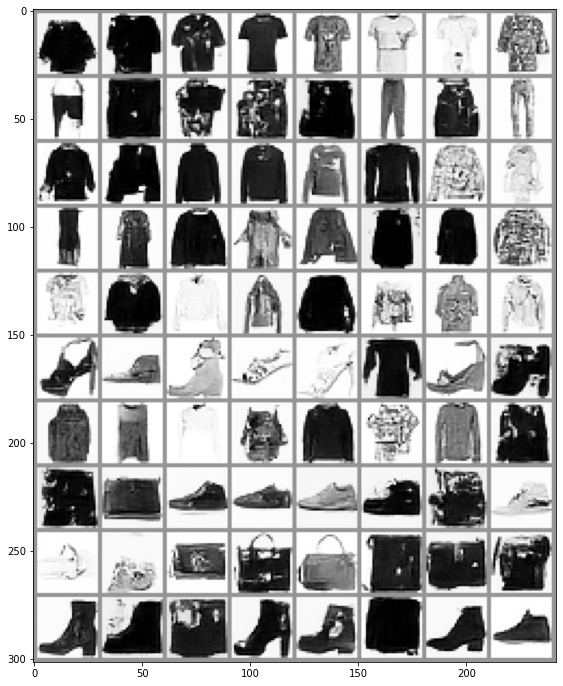

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap="Greys")
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

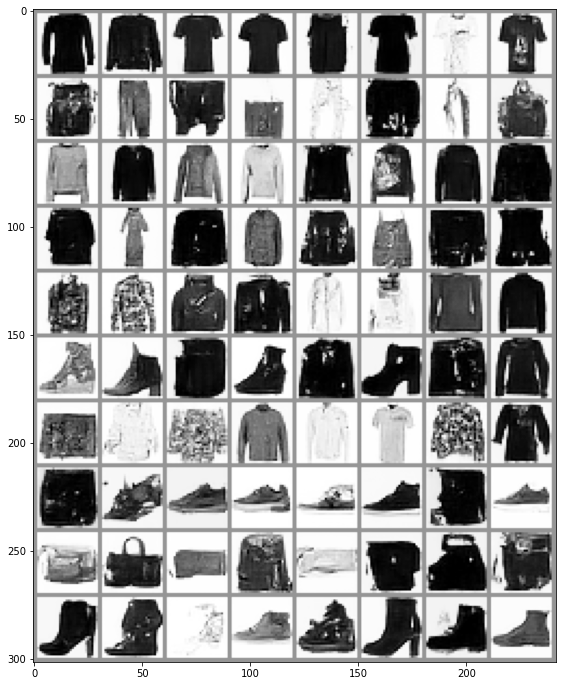

In [27]:
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

for i, t in enumerate(tqdm(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = model(x, t, y)[0]
    x = noise_scheduler.step(residual, t, x).prev_sample
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap="Greys")
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

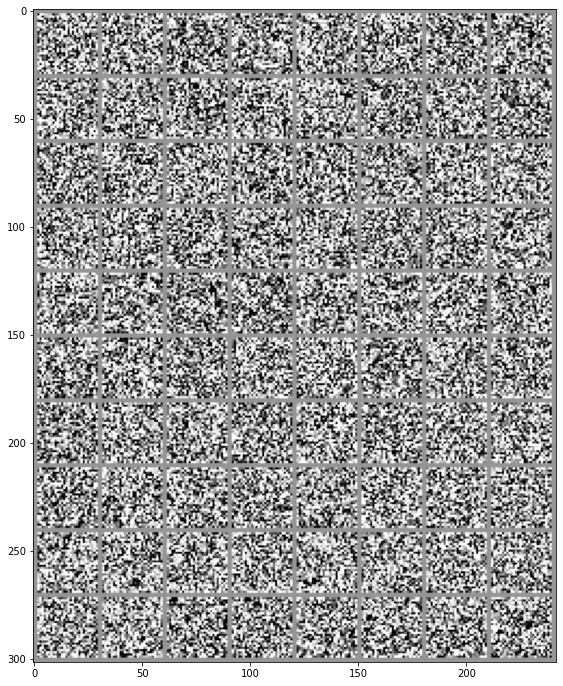

In [31]:
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

original_timesteps = noise_scheduler.num_train_timesteps

noise_scheduler.set_timesteps(num_inference_steps=50)
for i, t in enumerate(tqdm(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = model(x, t, y)[0]
    x = noise_scheduler.step(residual, t, x).prev_sample

noise_scheduler.set_timesteps(num_inference_steps=original_timesteps)
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap="Greys")
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

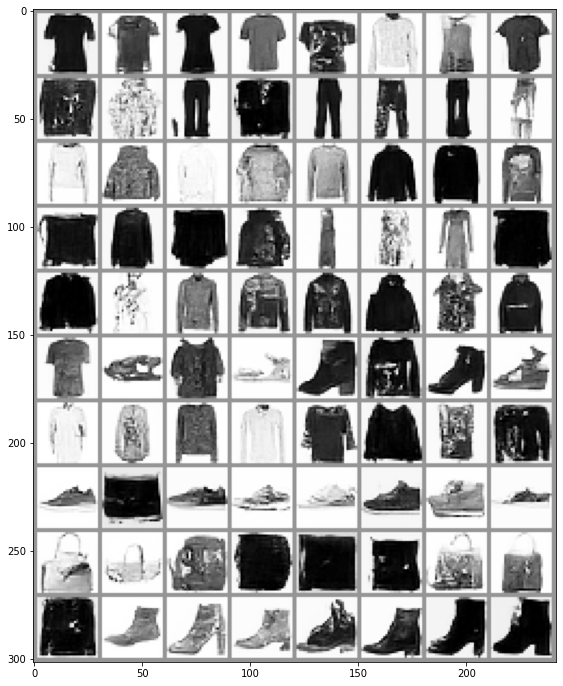

In [41]:
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)


for i, t in enumerate(tqdm(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = model(x, t, y)[0]
    x = noise_scheduler.step(residual, t, x).prev_sample

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap="Greys")
plt.show()

In [45]:
new_scheduler = DDIMScheduler.from_config(noise_scheduler.config)
new_scheduler.set_timesteps(num_inference_steps=100)
new_scheduler.num_inference_steps

100

  0%|          | 0/100 [00:00<?, ?it/s]

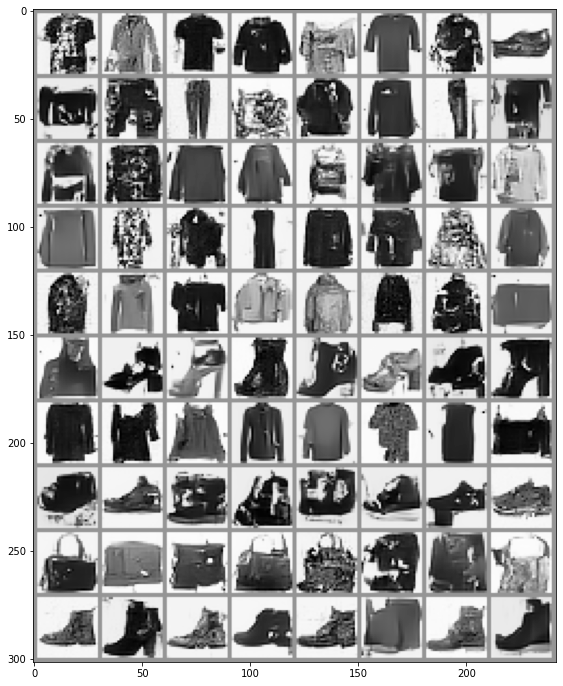

In [46]:
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)


for i, t in enumerate(tqdm(new_scheduler.timesteps)):
    with torch.no_grad():
        residual = model(x, t, y)[0]
    x = new_scheduler.step(residual, t, x).prev_sample

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap="Greys")
plt.show()